## Linear Regression of Active Ligand Yields

The following was used to develop a linear regression model to predict the observed yields of active ligands in the dataset. To keep the numbers of features used by the regressor, all combinations of two unique features were screened to find the best combination. Each combination was evaluated with the train R2/RMSE score and LOO cross-validation R2/RMSE. The best combination was then used to train the final model.

As well, SHAP values were calculated to determine individual feature importance in the model.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load data
df = pd.read_csv("../../data/ligand-qsar/alkylamine-ligand-modeling.tsv", sep="\t")
df = df[df["product_1_yield"] > 15].reset_index(drop=True)
df.fillna(0, inplace=True)

scaler = StandardScaler()
X = df.drop(columns=["ligand_1_name", "product_1_yield"])
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

y = df["product_1_yield"]

In [9]:
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from sklearn import metrics
from sklearn.model_selection import LeaveOneOut, RepeatedKFold, cross_val_predict

sns.set_theme(rc={"figure.figsize": (3.5, 3.5), "figure.dpi": 200}, style="ticks")


def evaluate_model(clf, X, y, title="Linear Regression", plot=True):
    """Evaluate a model using cross-validation."""
    clf.fit(X, y)
    print(X.columns)
    train_preds = clf.predict(X)
    r2 = metrics.r2_score(y, train_preds)
    rmse = metrics.root_mean_squared_error(y, train_preds)
    print(f"R^2: {r2:0.2f}")
    print(f"RMSE: {rmse:0.2f}")
    print()

    loo = LeaveOneOut()
    cv_preds = cross_val_predict(clf, X, y, cv=loo)
    loo_r2 = metrics.r2_score(y, cv_preds)
    loo_rmse = metrics.root_mean_squared_error(y, cv_preds)

    print(f"LOO RMSE: {loo_rmse:0.2f}")
    print(f"LOO R^2: {loo_r2:0.2f}")
    print()

    kfold = RepeatedKFold(n_repeats=5, n_splits=2, random_state=0)
    kfold_rmses = []
    kfold_r2s = []
    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        kfold_rmses.append(metrics.root_mean_squared_error(y_test, preds))
        kfold_r2s.append(metrics.r2_score(y_test, preds))

    kfold_r2 = round(np.mean(kfold_r2s), 2)
    kfold_rmse = round(np.mean(kfold_rmses), 2)
    kfold_r2_std = round(np.std(kfold_r2s), 2)
    kfold_rmse_std = round(np.std(kfold_rmses), 2)

    print(f"K-Fold RMSE: {kfold_rmse:0.2f} (±{kfold_rmse_std:0.2f})")
    print(f"K-Fold R^2: {kfold_r2:0.2f} (±{kfold_r2_std:0.2f})")

    fig, ax = plt.subplots()
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.plot([0, 100], [0, 100], color="grey", linestyle="--")

    sns.scatterplot(x=y, y=train_preds, s=200, ax=ax, color="#DDAA34")
    ax.set_xlabel("Observed Yield (%)")
    ax.set_ylabel("Predicted Yield (%)")

    if title:
        ax.set_title(title)

    ax.text(
        5,
        95,
        f"LOO R$^2$: {loo_r2:.2f}" "\nCV$_{\\text{5x2}}$ R$^2$: " f"{kfold_r2:0.2f}",
        fontsize=12,
        color="black",
        ha="left",
        va="top",
        bbox=dict(
            facecolor="white",
            alpha=1.0,
            edgecolor="lightgrey",
            boxstyle="round,pad=0.5,rounding_size=0.2",
        ),
    )

    # build label Text objects
    texts = []
    for x, ŷ, name in zip(y, train_preds, df["ligand_1_name"]):
        t = ax.text(
            x,
            ŷ,
            name,
            fontsize=10,
            ha="center",
            va="center",
            path_effects=[pe.withStroke(linewidth=3, foreground="white")],
        )
        texts.append(t)

    # single adjustment pass
    adjust_text(
        texts,
        ax=ax,
        expand_text=(1.05, 1.2),
        arrowprops=dict(
            arrowstyle="-",
            lw=0.6,
            color="gray",
            shrinkA=6,
            shrinkB=4,
            connectionstyle="arc3,rad=0.15",
        ),
    )
    coefficients = sorted(zip(X.columns, clf.coef_), key=lambda x: abs(x[1]), reverse=True)
    print(f"Equation: y = {clf.intercept_:.2f}", end="")
    for feature, coef in coefficients:
        if coef >= 0:
            print(f" + {coef:.2f}*{feature}", end="")
        else:
            print(f" - {abs(coef):.2f}*{feature}", end="")
    print()

    if len(coefficients) == 1:
        textstr = f"Feature 1: {coefficients[0][0]} ({coefficients[0][1]:.2f})"
    elif len(coefficients) == 2:
        textstr = "\n".join(
            (
                f"Feature 1: {coefficients[0][0]} ({coefficients[0][1]:.2f})",
                f"Feature 2: {coefficients[1][0]} ({coefficients[1][1]:.2f})",
            )
        )
    else:
        textstr = "\n".join(
            (
                f"Feature 1: {coefficients[0][0]} ({coefficients[0][1]:.2f})",
                f"Feature 2: {coefficients[1][0]} ({coefficients[1][1]:.2f})",
                f"Feature 3: {coefficients[2][0]} ({coefficients[2][1]:.2f})",
            )
        )

    ax.text(
        50,
        -18,
        textstr,
        fontsize=12,
        verticalalignment="top",
        horizontalalignment="center",
    )

    if plot:
        plt.show()

In [10]:
from itertools import combinations

from joblib import Parallel, delayed
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

run = True


def evaluate_combination(features: tuple):
    """Evaluate a combination of features."""
    clf = LinearRegression()
    clf.fit(X[list(features)], y)
    preds = clf.predict(X[list(features)])
    r2 = round(metrics.r2_score(y, preds), 2)
    rmse = round(metrics.root_mean_squared_error(y, preds), 2)

    if r2 < 0.8:
        return (features, r2, 0, 0)

    kfold = RepeatedKFold(n_repeats=5, n_splits=2, random_state=0)
    kfold_rmses = []
    kfold_r2s = []
    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train[list(features)], y_train)
        preds = clf.predict(X_test[list(features)])
        kfold_rmses.append(metrics.root_mean_squared_error(y_test, preds))
        kfold_r2s.append(metrics.r2_score(y_test, preds))

    cv5x2_r2 = round(np.mean(kfold_r2s), 2)

    kfold = LeaveOneOut()
    cv_preds = cross_val_predict(clf, X[list(features)], y, cv=kfold)
    kfold_r2 = round(metrics.r2_score(y, cv_preds), 2)
    kfold_rmse = round(metrics.root_mean_squared_error(y, cv_preds), 2)
    if kfold_r2 < 0:
        return (features, r2, rmse, 0, kfold_rmse)

    return (features, r2, kfold_r2, cv5x2_r2)


combinations_list = list(combinations(X.columns, 2))

print(f"Number of combinations: {len(combinations_list)}")

if run:
    results = Parallel(n_jobs=-1)(delayed(evaluate_combination)(features) for features in tqdm(combinations_list))

    results = sorted(results, key=lambda x: x[3], reverse=True)
    for features, r2, kfold_r2, cv5x2_r2 in results[:5]:
        print(f"Features: {list(features)}, R2: {r2}, CV5x2 R2: {cv5x2_r2}, LOO R2: {kfold_r2}")

Number of combinations: 11026


100%|██████████| 11026/11026 [00:04<00:00, 2509.59it/s]


Features: ['min_fukui_f_minus_carb_oh', 'max_buried_volume_2.0A'], R2: 0.92, CV5x2 R2: 0.73, LOO R2: 0.83
Features: ['min_partial_charge_carbonyl_oxygen', 'max_distance_Pd_P'], R2: 0.91, CV5x2 R2: 0.7, LOO R2: 0.85
Features: ['distance_carb_C_OH', 'min_fukui_f_minus_amine_nitrogen'], R2: 0.87, CV5x2 R2: 0.6, LOO R2: 0.8
Features: ['min_fukui_f_minus_aryl_carbon', 'max_partial_charge_metal'], R2: 0.81, CV5x2 R2: 0.58, LOO R2: 0.63
Features: ['fukui_f_minus_amine_nitrogen', 'min_fukui_f_minus_amine_nitrogen'], R2: 0.82, CV5x2 R2: 0.57, LOO R2: 0.68


Index(['min_fukui_f_minus_carb_oh', 'max_buried_volume_2.0A'], dtype='object')
R^2: 0.92
RMSE: 6.03

LOO RMSE: 8.69
LOO R^2: 0.83

K-Fold RMSE: 10.07 (±2.69)
K-Fold R^2: 0.73 (±0.12)
Equation: y = 35.71 + 15.26*max_buried_volume_2.0A + 14.38*min_fukui_f_minus_carb_oh


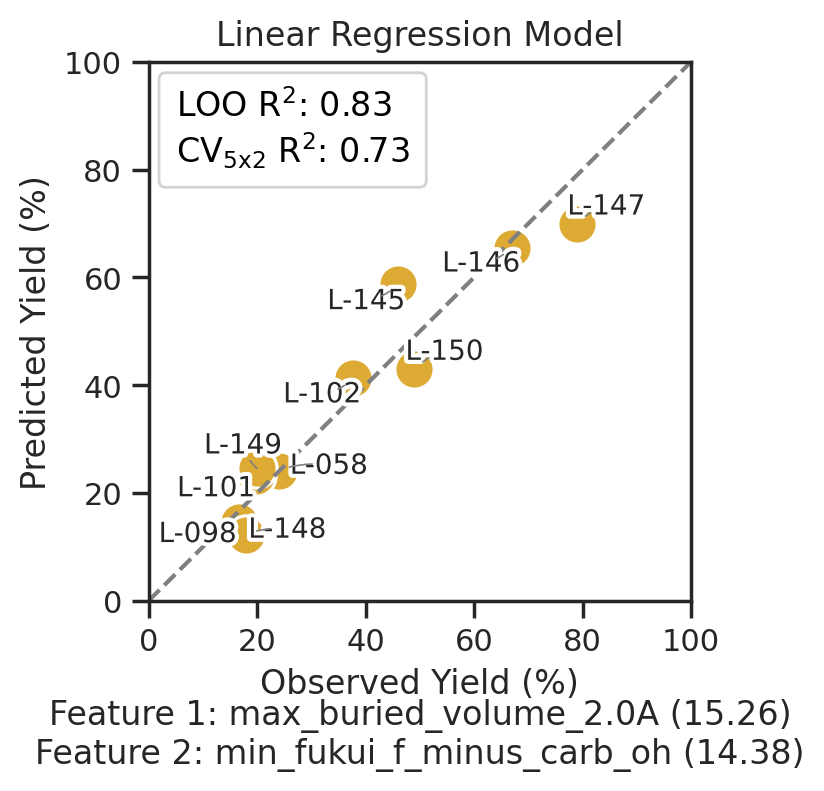

In [12]:
evaluate_model(
    LinearRegression(),
    X[list(results[0][0])],
    y,
    title="Linear Regression Model",
)

### Control Experiments

Index(['min_fukui_f_minus_carb_oh', 'max_buried_volume_2.0A'], dtype='object')
R^2: 0.09
RMSE: 20.01

LOO RMSE: 30.79
LOO R^2: -1.15

K-Fold RMSE: 35.77 (±11.22)
K-Fold R^2: -5.62 (±9.49)
Equation: y = 40.95 + 21.84*max_buried_volume_2.0A - 15.32*min_fukui_f_minus_carb_oh


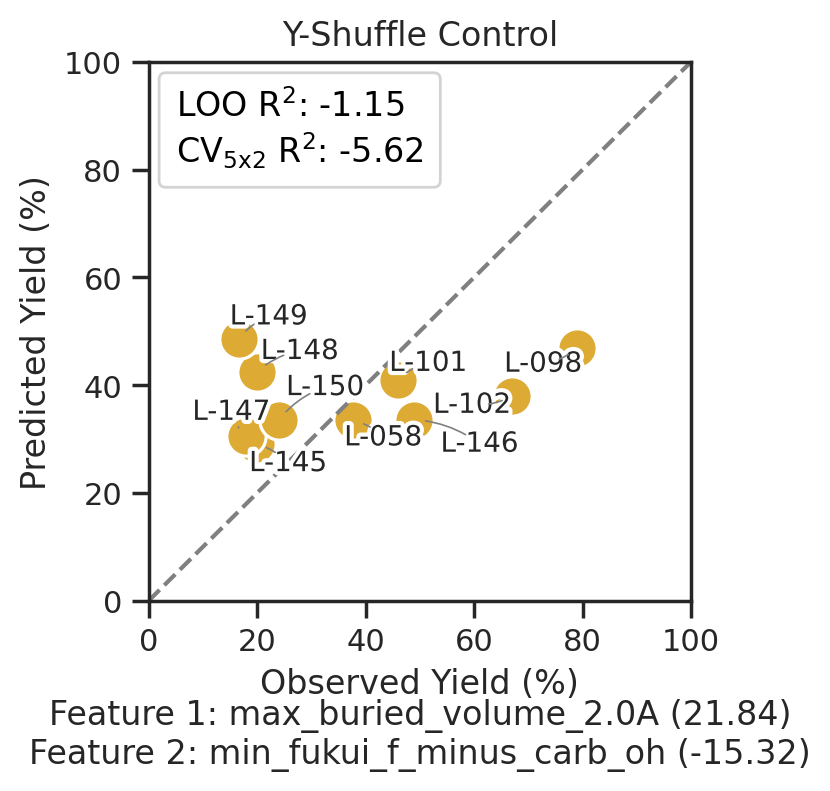

In [13]:
y_shuffle = y.copy().sample(frac=1).reset_index(drop=True)

clf = LinearRegression()
evaluate_model(clf, X[list(results[0][0])], y_shuffle, title="Y-Shuffle Control")


Index(['min_fukui_f_minus_carb_oh', 'max_buried_volume_2.0A'], dtype='object')
R^2: 0.62
RMSE: 13.00

LOO RMSE: 18.38
LOO R^2: 0.23

K-Fold RMSE: 24.59 (±10.58)
K-Fold R^2: -0.70 (±1.43)
Equation: y = 9.76 + 27.72*min_fukui_f_minus_carb_oh - 26.79*max_buried_volume_2.0A


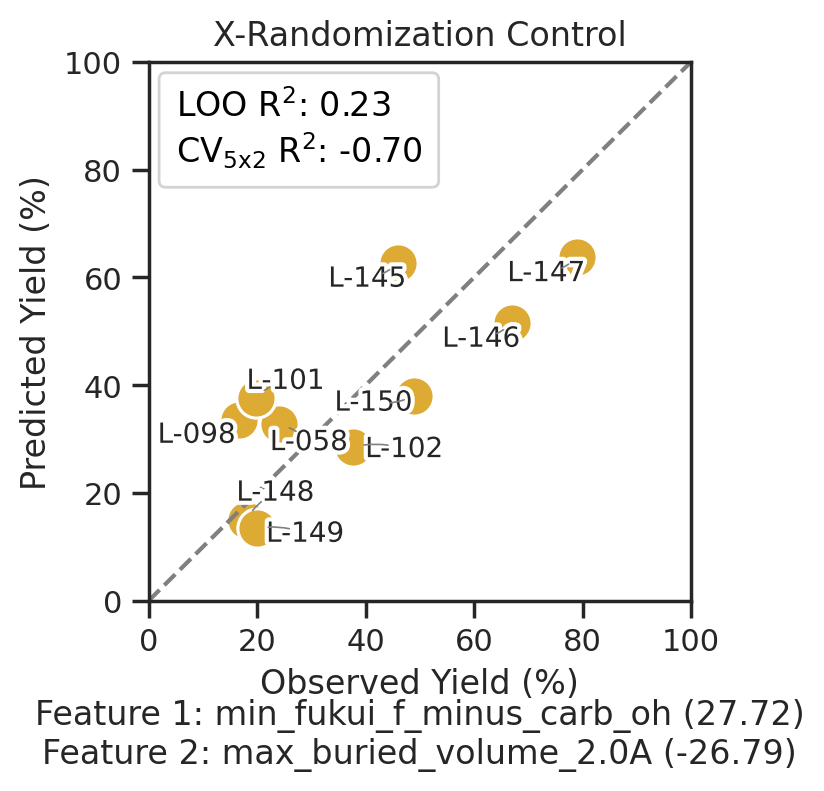

In [14]:
def generate_random_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """Generate a random dataframe with the same shape and distribution as the input dataframe.

    This function ensures that each column's random data matches the original min and max values.

    Args:
        df (pd.DataFrame): DataFrame to generate random data from.

    Returns:
        pd.DataFrame: DataFrame with random data.
    """
    np.random.seed(0)
    df = df.copy()
    for col in df.columns:
        df[col] = np.random.uniform(low=df[col].min(), high=df[col].max(), size=df[col].shape)
    return df


X_rand = generate_random_dataframe(X[list(results[0][0])])

clf = LinearRegression()
evaluate_model(clf, X_rand, y, title="X-Randomization Control", plot=False)